# Full trajectory analysis

First, we load in all necessary packages and set file paths

In [1]:
import scanpy as sc
import scvelo as scv
import motivo
from scipy.ndimage.filters import uniform_filter1d
import sys
sys.path.insert(1, "/Users/carolinaatria/Desktop/ADesktop/Studium/Master/master_thesis/sponge/data_from_roger/python/PART1")
from marker_ids_hardcoded import marker_data
marker_gene_names = ["Myc","Vasa","Piwi","Eif","Chek2","Phgdh","Mdh1","Whrn","Espn","Tekt","Myh7","Alas2","Pygm","Silicatein"]
sc.settings.verbosity = 0
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random as rd
import re
import matplotlib.pyplot as plt
from numpy import unique
import json
from scipy.stats import pearsonr
from collections import defaultdict
import os
marker_list = marker_data(version="isoseq")
from Bio import SeqIO
from traj_cells import return_trajectory_cells,traj_json_files
adata = sc.read_h5ad("/Users/carolinaatria/Desktop/ADesktop/Studium/Master/master_thesis/sponge/data_from_roger/python/data.nosync/saved_analysis/subdom.h5ad")
genome_fasta_file = "/Users/carolinaatria/Desktop/ADesktop/Studium/Master/master_thesis/sponge/data_from_roger/python/data.nosync/genome_assembly/SDO_hapA_v0.1.fasta"
genome_bed_file = "/Users/carolinaatria/Desktop/ADesktop/Studium/Master/master_thesis/sponge/data_from_roger/python/data.nosync/Sdom_Isoseq_222252/cluster_analysis/all_tss.bed"
proteome_file = "/Users/carolinaatria/Desktop/ADesktop/Studium/Master/master_thesis/sponge/data_from_roger/python/data.nosync/mus_musculus/proteome/proteome_shorthand/proteome_modified.fasta"

Select trajectory and sort by pseudotime

In [2]:
trajectory_type = "choano"
barcodes = return_trajectory_cells(trajectory_type)
selected_trajectory = adata[barcodes]
selected_trajectory.uns['log1p']["base"] = None

sorted_cells = selected_trajectory.obs.sort_values("ct_pseudotime").index.to_list()
pseudotime_sorted_cells = selected_trajectory.obs.sort_values("ct_pseudotime")["ct_pseudotime"].to_list()
plt.rcParams["figure.figsize"] = [16,9]
x = range(0,70,2)
pseudotime_bins = []
for i in x:
    pseudotime_bins.append(i/100)

Calculate pearson correlation of all gene expressions compare to marker gene expression (eg Myc)

In [31]:
file_path = traj_json_files(trajectory_type) #possible types: choano, intermed, metabolo, pinaco

with open(file_path, 'r') as file:
    expression_loaded = json.load(file)

marker_gene = "SUB2.g5379" #MYC: SUB2.g5379 #Ybox protein: SUB2.g7130
r_value_threshold = 0.9 #if we want to select genes based on their correlation coefficient with the marker gene, we can set the threshold here

window_size = 10 #if we want to smooth the expression profiles for plotting, we can set the window size here

smoothed_expression_dict = {}

# Iterate over all the genes in the original dictionary
for gene, expr_list in expression_loaded.items():
    smoothed_expr = uniform_filter1d(expr_list, size=window_size)
    smoothed_expression_dict[gene] = smoothed_expr
gene_expression_dict = expression_loaded
# Get the expression of your marker gene
marker_expr = np.array(gene_expression_dict[marker_gene])

selected_genes = []
p_val_list = []

# Iterate over all the genes in the original dictionary, calculate pearson correlation coefficient between current gene and marker gene expression
for gene, expr_list in gene_expression_dict.items():
    corr_coef, p_value = pearsonr(marker_expr, np.array(expr_list))
    # Check if the correlation coefficient is above the threshold
    if corr_coef > r_value_threshold and p_value < 0.05:
        selected_genes.append((gene, corr_coef))
        p_val_list.append(p_value)

# Sort the selected genes based on their correlation coefficients in descending order
selected_genes = sorted(selected_genes, key=lambda x: x[1], reverse=True)

gene_ids = []
for gene, similarity_score in selected_genes:
    gene_ids.append(gene)
print("With a correlation coefficient above %.2f (sorted by similarity), %i genes were selected" % (r_value_threshold,len(gene_ids)))

With a correlation coefficient above 0.90 (sorted by similarity), 1158 genes were selected


With the selected genes, we can now do a TSS analysis to figure out how broad we should set our window in which we will look for the presence of a TF motif

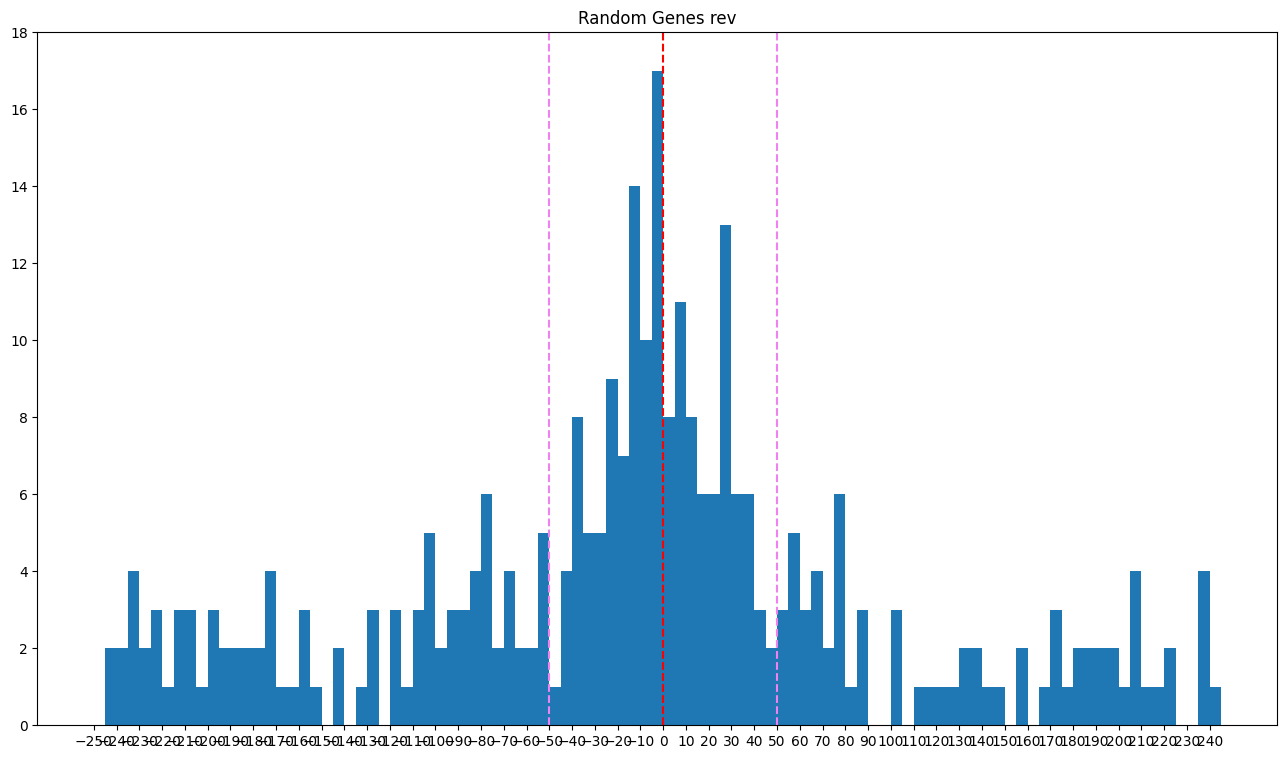

In [72]:
confirmed_myc_targets = gene_ids[:1000]

#if we want to compare to a random sample to see the "noise" level for a specific motif uncomment the next line of code
# genes_of_interest = rd.sample(gene_list,1000)

myc_binding_sequence = "CACGTG" #Myc motif sequence

genome = SeqIO.to_dict(SeqIO.parse(genome_fasta_file, "fasta"))
tss_data = []
gene_list = []

with open(genome_bed_file, "r") as file:
    for line in file:
        chromosome, start, end, gene_name = line.strip().split("\t")
        tss_data.append((chromosome, int(start), int(end), gene_name))
        gene_list.append(gene_name)

search_range = 250
selected_sequence = {}
TSS_dict = {}
# Iterate over each TSS
for chromosome, start, end, gene_name in tss_data:
    if gene_name in genes_of_interest:
        TSS_dict[gene_name] = start
        selected_sequence[gene_name] = genome[chromosome][start - search_range: end + search_range].seq

motif_distance = []
for gene in genes_of_interest:
    start = TSS_dict[gene]
    sequence = selected_sequence[gene]
    sequence_str = str(sequence)
    reverse_motif = str(myc_binding_sequence[::-1])
    motif_match = re.search(myc_binding_sequence, sequence_str)
    if motif_match:
        hit = motif_match.start()
        motif_distance.append(hit - search_range)
    else:
        motif_match = re.search(reverse_motif, sequence_str)
        if motif_match:
            hit = motif_match.start()
            motif_distance.append(hit - search_range)
        else:
            motif_distance.append(float("inf"))
plt.rcParams["figure.figsize"] = [16,9]

plt.hist(motif_distance, bins=range(-search_range, search_range, 5))
plt.axvline(x=0, color="red", linestyle="dashed")
plt.axvline(x=50, color="violet", linestyle="dashed")
plt.axvline(x=-50, color="violet", linestyle="dashed")
plt.ylim(0,18)
plt.xticks(range(-search_range, search_range, 10))
plt.title("Random Genes rev")
plt.show()

Find motives that are significantely present in our list of gene IDs

In [5]:
import motivo
# don't forget to put trajectory and TF in csv file name!
csv_file = "tmp/motives_ybox_metabolo_0.9.csv"
motivo.motif_finder(genome_bed_file,genome_fasta_file,gene_ids,csv_file,k=5,size=30)

working with 1024 k-mers


In [228]:
# if you want to use genes enriched in one specific cell type instead of the correlation analysis, use this to read in the gene names
file_path = '/Users/carolinaatria/Desktop/ADesktop/Studium/Master/master_thesis/sponge/data_from_roger/python/thesis/cluster_7.csv'
df = pd.read_csv(file_path)
gene_ids = df["gene_ids"].to_list()

3082


in whole genome: 683 5.0 percent


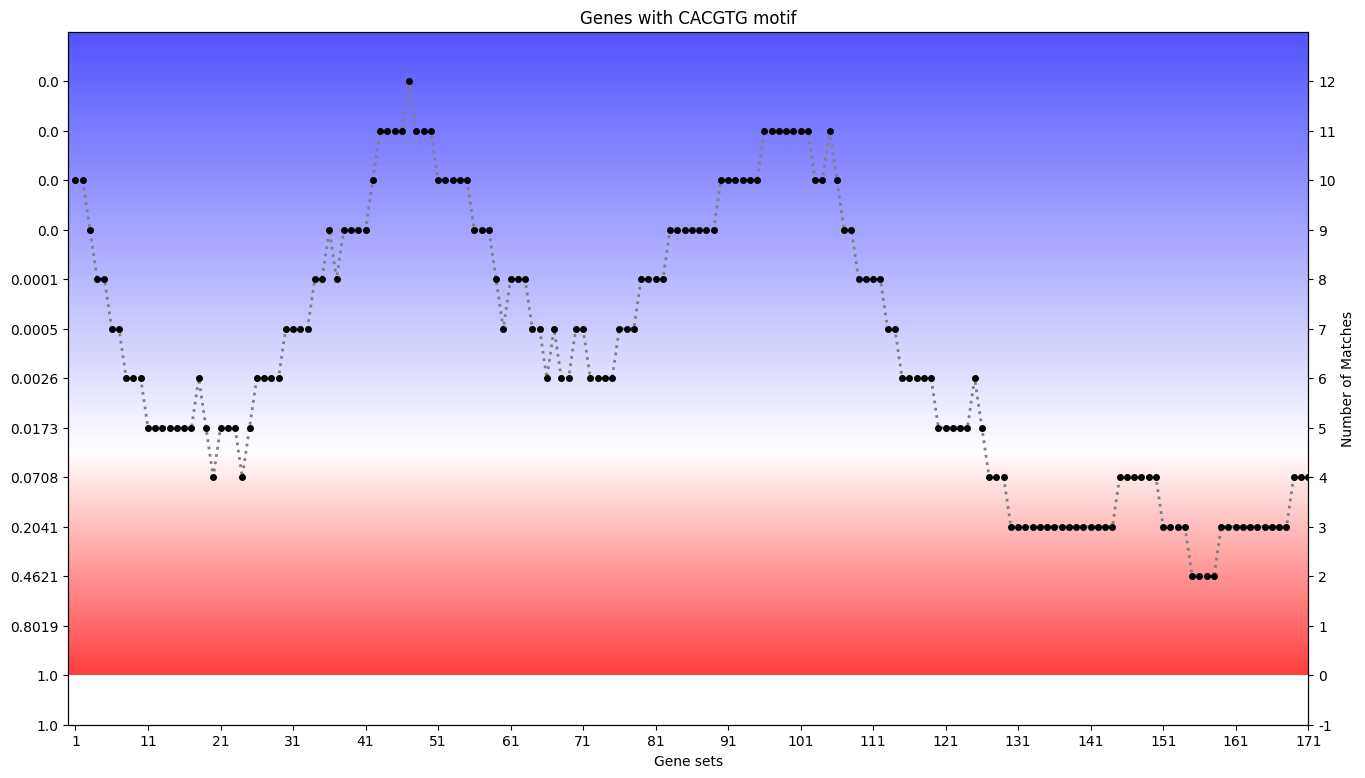

In [18]:
motif_list = ["CACGTG","CCAAT"]
motivo.motif_plotter(gene_ids[:200],30,genome_bed_file,motif_list,genome_fasta_file,stats=False,fixed_height=13,operator="OR")

Extract a list of all genes, that are in at least one significant gene set

In [251]:
genes_with_motif = motivo.target_genes(gene_ids[:168],genome_bed_file,motif="CACGTG",fasta_file=genome_fasta_file,size=30) #159

blast and reciprocal blast against mouse database

In [31]:
transcriptome_file = "/path/to/file"  # Path to your transcriptome fasta file
output_file = "tmp/myc_targets_sd.fasta"  # Path to the output file to save the sequences

# Open the output file for writing
with open(output_file, "w") as output_handle:
    # Iterate over the selected genes in the specified order
    for selected_gene in full_list:
        # Iterate over the sequences in the transcriptome fasta file
        for record in SeqIO.parse(transcriptome_file, "fasta"):
            gene_name = record.id  # Assuming the gene name is the sequence identifier

            # Check if the current gene matches the selected gene
            if gene_name == selected_gene:
                # Write the selected gene sequence to the output file
                SeqIO.write(record, output_handle, "fasta")
                break  # Exit the inner loop once the gene is found

#./blast.sh tmp/myc_targets_sd.fasta tmp/1
!./blast.sh tmp/myc_targets_sd.fasta tmp/1 && awk -F',' '!seen[$1]++' tmp/1 > tmp/2

file_path = "tmp/2" 

second_items = []

with open(file_path, 'r') as file:
    items=file.read().split("\n")
    for item in items[:len(items)-1]:
        second_items.append(str(item.split(",")[1]))

os.remove(output_file)
output_file = "tmp/myc_targets_mm.fasta"

# Create a set to store the selected gene names
selected_genes_set = set(second_items)

# Open the output file for writing
with open(output_file, "w") as output_handle:
    # Iterate over the sequences in the proteome fasta file
    for record in SeqIO.parse(proteome_file, "fasta"):
        gene_name = record.id  # Assuming the gene name is the sequence identifier
        
        # Check if the current gene is in the set of selected genes
        if gene_name in selected_genes_set:
            # Write the selected gene sequence to the output file
            SeqIO.write(record, output_handle, "fasta")
            
            # Remove the gene from the selected_genes_set
            selected_genes_set.remove(gene_name)
            
            # Check if all selected genes have been found
            if len(selected_genes_set) == 0:
                break

!./recip_blast.sh tmp/myc_targets_mm.fasta tmp/3 && awk -F',' '!seen[$1]++' tmp/3 > tmp/4

input_file1 = "tmp/2"  # Path to the first input file
input_file2 = "tmp/4"  # Path to the second input file
full_blast_file = "tmp/choano_ybox_0.6.xlsx"

with open(input_file1, 'r') as file:
    list1=file.read().split("\n")
with open(input_file2, 'r') as file:
    list2=file.read().split("\n")
import pandas as pd

# Split the elements of list1 into separate columns
list1_split = [item.split(',') for item in list1]
list1_df = pd.DataFrame(list1_split, columns=['Sponge gene', 'Mouse protein', 'e-value'])

# Split the elements of list2 into separate columns
list2_split = [item.split(',') for item in list2]
list2_df = pd.DataFrame(list2_split, columns=['Mouse protein', 'reciprocal sponge match', 'e-value'])

# Merge the two dataframes based on the 'Mouse ID' column
merged_df = pd.merge(list1_df, list2_df, on='Mouse protein', how='left')

# Save the merged dataframe to an Excel file
merged_df.to_excel(full_blast_file, index=False)

print("Merged data saved to '%s'." % full_blast_file)
os.remove(output_file)
os.remove(input_file1)
os.remove(input_file2)



Building a new DB, current time: 10/10/2023 08:03:53
New DB name:   /Users/carolinaatria/Desktop/ADesktop/Studium/Master/master_thesis/sponge/data_from_roger/python/data.nosync/mus_musculus/proteome/uniprot-compressed_true_download_true_format_fasta_query__28_28prote-2023.06.03-16.55.21.10.fasta
New DB title:  /Users/carolinaatria/Desktop/ADesktop/Studium/Master/master_thesis/sponge/data_from_roger/python/data.nosync/mus_musculus/proteome/uniprot-compressed_true_download_true_format_fasta_query__28_28prote-2023.06.03-16.55.21.10.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /Users/carolinaatria/Desktop/ADesktop/Studium/Master/master_thesis/sponge/data_from_roger/python/data.nosync/mus_musculus/proteome/uniprot-compressed_true_download_true_format_fasta_query__28_28prote-2023.06.03-16.55.21.10.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 55275 sequences in 1.01006 seconds.




Building a new DB, current time: 10/10/